# Importing Module and define directories

In [917]:
%matplotlib inline
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP
from utils.preprocessing import split,StandardScaler, MinMaxScaler
from utils.results import plot_results, output_correlations
from utils.regressor import regressor
from utils.trick_output import lin_sin_lin, trick_params
import ensemble
importlib.reload(ensemble)
from ensemble import bagging_ensemble

# Train - Validation Split

In [2]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = MinMaxScaler()
norm_labels = MinMaxScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)
all_norm_data = np.column_stack((data, labels))

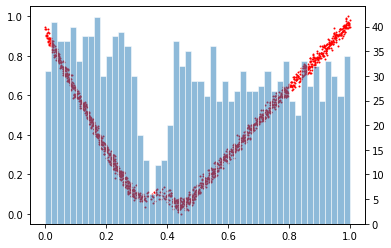

In [3]:
hard_out = labels[:, 1]
easy_out = labels[:, 0]

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.scatter(hard_out, easy_out, s = 1, c='red')
ax_right.hist(hard_out, bins = 50, alpha = 0.5, ec="white")
plt.show()

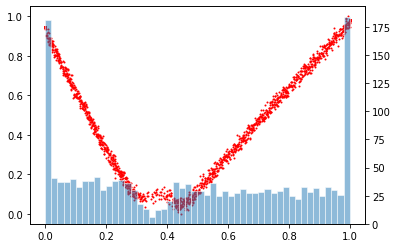

In [4]:
def generate_in_middle(dataset, d1, d2):
    mid = (dataset[d1, :] + dataset[d2, :])/2
    return np.row_stack((dataset, mid))

def expand_in_middle(n_new_data, dataset, lim_inf, lim_sup, unbal_feature):
    data_copy = np.copy(dataset)
    mask_inf = data_copy[:, unbal_feature] > lim_inf
    mask_sup = data_copy[:, unbal_feature] < lim_sup
    mid_data = data_copy[np.logical_and(mask_inf, mask_sup)]
    rng = np.random.default_rng()
    for i in range(n_new_data):
        val = rng.normal(loc = (lim_inf + lim_sup)/2, 
                         scale = np.abs((lim_inf - lim_sup)/2))
        sort_for_val = np.argsort(np.abs(data_copy[:,unbal_feature]-val))
        d1 = sort_for_val[0]
        d2 = sort_for_val[1]
        data_copy = generate_in_middle(data_copy, d1, d2)
    return data_copy

new_dataset = expand_in_middle(150, all_norm_data, 1.3, 1.7, 11)
new_dataset = expand_in_middle(150, new_dataset, -1.6, -1.4, 11)

hard_out = new_dataset[:, 11]
easy_out = new_dataset[:, 10]

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.scatter(hard_out, easy_out, s = 1, c='red')
ax_right.hist(hard_out, bins = 50, alpha = 0.5, ec="white")
plt.show()

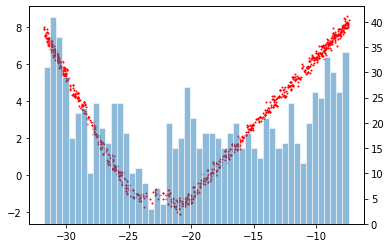

In [5]:
def generate_in_middle(dataset, d1, d2):
    mid = (dataset[d1, :] + dataset[d2, :])/2
    return np.row_stack((dataset, mid))

def remove_in_middle(n, dataset, lim_inf, lim_sup, unbal_feature):
    data_copy = np.copy(dataset)
    mask_inf = data_copy[:, unbal_feature] > lim_inf
    mask_sup = data_copy[:, unbal_feature] < lim_sup
    left_data = data_copy[data_copy[:, unbal_feature] < lim_inf]
    mid_data = data_copy[np.logical_and(mask_inf, mask_sup)]
    right_data = data_copy[data_copy[:, unbal_feature] > lim_sup]
    rng = np.random.default_rng()
    mid_data = rng.choice(mid_data, size = len(mid_data) - n )
    data_copy = np.row_stack((left_data, mid_data))
    data_copy = np.row_stack((data_copy, right_data))
    return data_copy

new_dataset = remove_in_middle(500, raw_data, -30, -10, 11)

hard_out = new_dataset[:, 11]
easy_out = new_dataset[:, 10]

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.scatter(hard_out, easy_out, s = 1, c='red')
ax_right.hist(hard_out, bins = 50, alpha = 0.5, ec="white")
plt.show()

In [6]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

frac_test=0.1
data, test_set, labels, test_labels = split(data, labels, 
                                            kind="hold_out",frac_training=1-frac_test)

In [7]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)


# Define the MLP

## Train the model

In [890]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

frac_test=0.1
data, test_set, labels, test_labels = split(data, labels, 
                                            kind="hold_out",frac_training=1-frac_test)

frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                                     frac_training=frac_training)


train_labels1 = train_labels[:,1].reshape((len(train_labels),1))
val_labels1 = val_labels[:,1].reshape((len(val_labels), 1))

In [892]:
other_output= train_labels[:,0]
lin_output= train_labels[:,1]

x = np.copy(lin_output)
y = np.copy(other_output)

used_data = np.column_stack((input_data, train_labels))

xx = np.linspace(np.min(x), np.max(x), 1000)
params = trick_params(norm_name = 'std')

reg = regressor()
reg.fit(x, y, lin_sin_lin, params)
popt_sin = reg.best_params

# fig, axs = plt.subplots(1, 2, figsize = (10, 3))
# axs[0].plot(xx,lin_sin_lin(xx,*popt_sin))
# axs[0].scatter(x, y, s = 5, label ='real', alpha = 0.3, c='orange')
# axs[0].set_title('fit func vs data')
# axs[1].scatter(x, y-lin_sin_lin(x,*popt_sin), s = 5)
# axs[1].set_title('residual')
# plt.show()
# RMS = np.sqrt(np.sum((y-lin_sin_lin(x,*popt_sin))**2))
# print(f'RMS = {RMS} (root sum of squared residual)')

reg.reason

'kmax iteration reached'

In [895]:
structure=[10,5, 2]
act_func=[("tanh",1)]*(len(structure)-1) + [("linear",1)]
start=xavier(structure)

N_epoch = 50000
lamb=1e-6; batch_size = 100; alpha=0.1 ; nesterov=True ; eta_function=5e-5
beta=0.9
netw = MLP(structure, func=act_func,starting_points=start)

In [896]:
netw.train(input_data, train_labels , val_data, val_labels,
           epoch = N_epoch,
           batch_size=batch_size,
           eta = eta_function, lamb = lamb,alpha=alpha,
           nesterov=nesterov,RMSProp=True,beta=beta,
           patience = 100, error_threshold = 0.)

Epoch 4487:  [train MEE = 0.2658]  [val MEE = 0.2763]                              
Elapsed time: 31.427489757537842 s


# Plot results

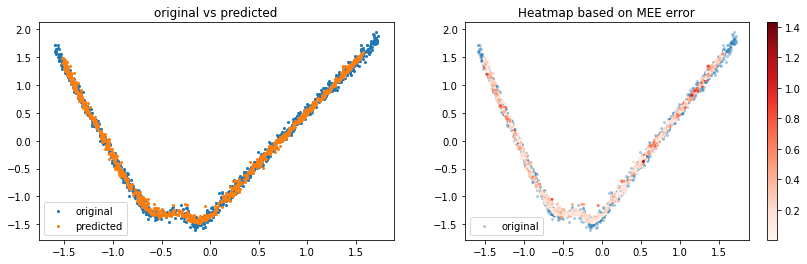

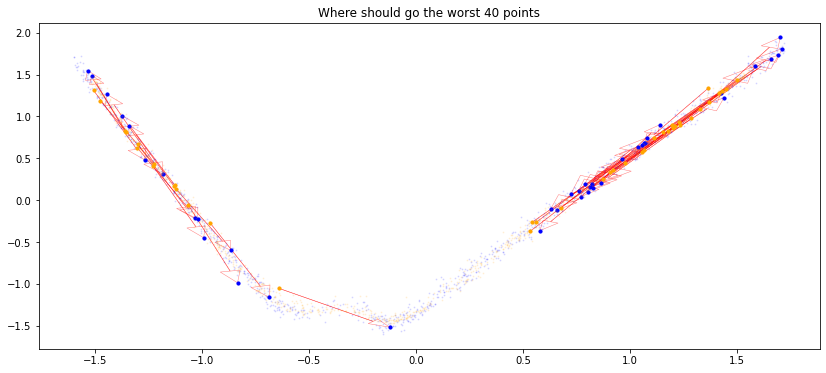

[ 217  465  408  373  430  850  476  407  128  725  885 1050  819  527
  533  937  756  157 1055  866   91  347  521  160 1051  918  596   39
  389  867   49 1057  233  642  357  957   52  474  452  663]


In [897]:
import utils.results
importlib.reload(utils.results)
from utils.results import plot_results, output_correlations

w = output_correlations(netw, input_data, train_labels, plot_arrow_worse = 40,
                    fit_func = lin_sin_lin, func_args = popt_sin
                   )

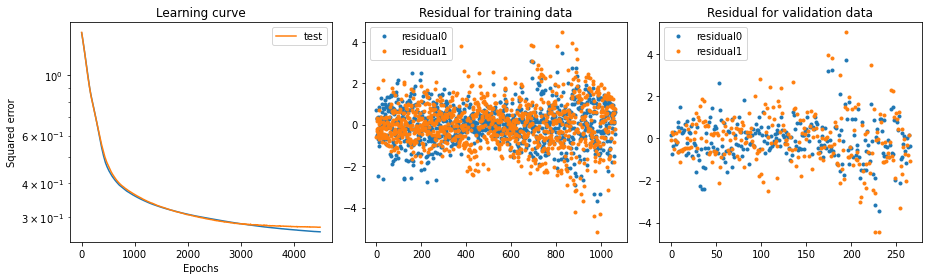

final train error: 1.1181277305674595
final val error: 1.195317312860601


In [898]:
plot_results(netw, input_data, val_data, train_labels, val_labels, 
             func = lin_sin_lin, func_args = popt_sin, mean_fit = True,
             norm = norm_labels.inverse_transform,
             sortidx = 1)

## Try an ensemble

In [1054]:
import ensemble
importlib.reload(ensemble)
from ensemble import bagging_ensemble

In [1083]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)


frac_test=0.1
data, test_set, labels, test_labels = split(data, labels, 
                                            kind="hold_out",frac_training=1-frac_test)

frac_training=0.8
dict_split = {'kind':'hold_out', 'frac_training':frac_training}

#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)

structure=[15, labels.shape[-1]]
act_func=["lrelu"]*(len(structure)-1) + ["linear"]
start=xavier(structure)

dict_MLP = {'structure':structure, 'func':act_func, 'starting_points':xavier(structure)}

N_epoch = 10000
lamb=0.#1e-4
batch_size = -1 #-1 for batch gradient descent
alpha=5e-1
nesterov=True
eta=5e-4
beta=0.9
dict_train = {'epoch':N_epoch, 'batch_size':batch_size, 'eta':eta, 'lamb':lamb, 
              'alpha':alpha, 'nesterov':nesterov, 'RMSProp':True, 'beta':beta,
              'error_threshold':0., 'patience':100, 'verbose':True}

bagg = bagging_ensemble(5)
bagg.train(data, labels, MLP, dict_MLP, dict_train, split, dict_split)

act_func=["tanh"]*(len(structure)-1) + ["linear"]
dict_MLP_tanh = {'structure':structure, 'func':act_func, 'starting_points':xavier(structure)}
bagg.train(data, labels, MLP, dict_MLP_tanh, dict_train, split, dict_split)

0/5
Epoch 1329:  [train MEE = 0.2252]  [val MEE = 0.2397]                              
Elapsed time: 3.1960642337799072 s
1/5
Epoch 1062:  [train MEE = 0.2698]  [val MEE = 0.2668]                              
Elapsed time: 2.571183919906616 s
2/5
Epoch 1474:  [train MEE = 0.2262]  [val MEE = 0.2283]                              
Elapsed time: 3.542968273162842 s
3/5
Epoch 1396:  [train MEE = 0.2421]  [val MEE = 0.2615]                              
Elapsed time: 3.4231064319610596 s
4/5
Epoch 1510:  [train MEE = 0.2166]  [val MEE = 0.2452]                              
Elapsed time: 3.720182418823242 s
5/10
Epoch 1512:  [train MEE = 0.2196]  [val MEE = 0.2254]                              
Elapsed time: 4.02568793296814 s
6/10
Epoch 1638:  [train MEE = 0.1874]  [val MEE = 0.1951]                              
Elapsed time: 4.41540002822876 s
7/10
Epoch 1009:  [train MEE = 0.2086]  [val MEE = 0.2233]                              
Elapsed time: 2.7479333877563477 s
8/10
Epoch 1293:  [t

In [1084]:
bagg.prune_ensemble

Pruned 1/10 classifier


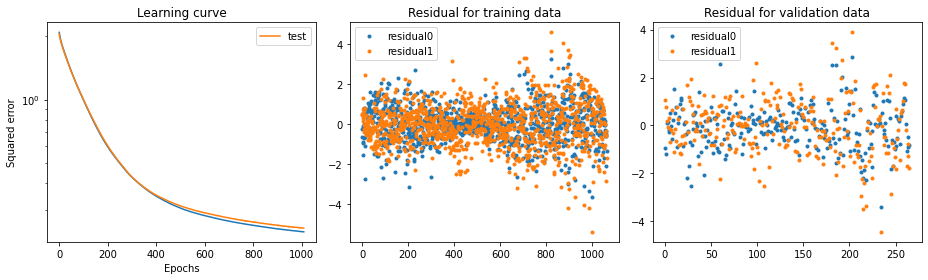

final train error: 1.1335766968075196
final val error: 1.1541045064816278


In [1085]:
frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                               frac_training=frac_training)

plot_results(bagg, input_data, val_data, train_labels, val_labels,func = lin_sin_lin, func_args = popt_sin,
             mean_fit = True, norm = norm_labels.inverse_transform, 
             sortidx = 1)

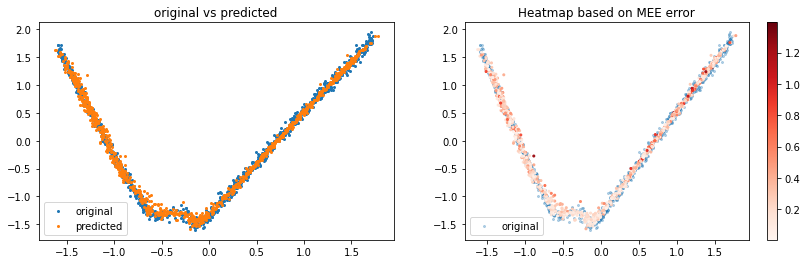

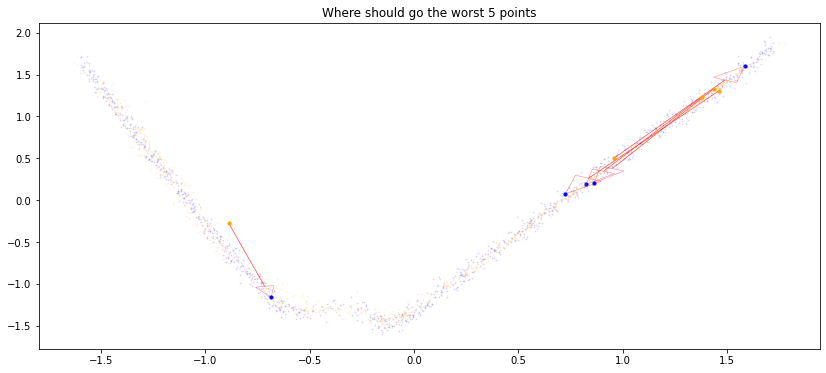

[452 867  49  52 663]


array([452, 867,  49,  52, 663])

In [1086]:
output_correlations(bagg, input_data, train_labels, plot_arrow_worse = 5,
                    fit_func = lin_sin_lin, func_args = popt_sin
                   )